In [79]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
import imutils
%matplotlib inline



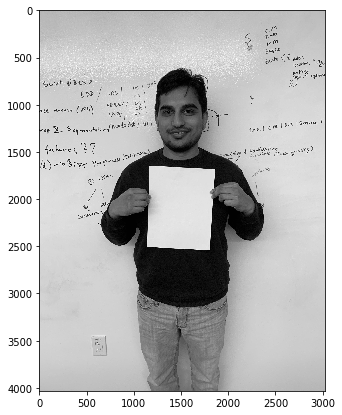

In [70]:
plt.rcParams['figure.figsize'] = [21.0, 7.0]
filename = 'rajeev.jpg'
img = cv2.imread(filename)
gray = cv2.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(gray, cmap = 'gray')
plt.show()

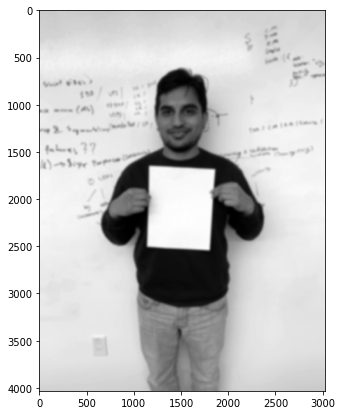

In [64]:
r = 75
img_gaussian = cv2.GaussianBlur(gray,(r,r),0)
kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
img_prewittx = cv2.filter2D(img_gaussian, -1, kernelx)
img_prewitty = cv2.filter2D(img_gaussian, -1, kernely)

plt.imshow(img_gaussian, cmap = 'gray')
plt.show()

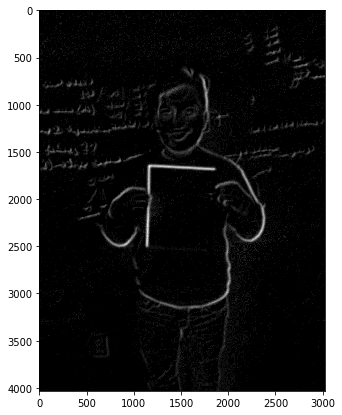

In [59]:
k = 1
img_sobelx = cv2.Sobel(img_gaussian,cv2.CV_8U,1,0,ksize=k)
img_sobely = cv2.Sobel(img_gaussian,cv2.CV_8U,0,1,ksize=k)
img_sobel = img_sobelx + img_sobely
plt.imshow(img_sobel, cmap = 'gray')

In [56]:
np.shape(img_sobel/255)

(4032, 3024)

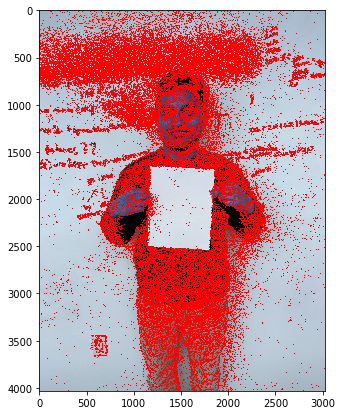

In [63]:
dst = cv2.cornerHarris(img_sobel, 5, ksize = 5, k = 4)
#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.5*dst.max()]=[255,0,0]
plt.imshow(img)

In [122]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries, find_boundaries
from skimage.util import img_as_float

In [216]:
fl_img = img_as_float(img)

filename = 'rajeev.jpg'
img = cv2.imread(filename)
r_img = imutils.resize(img, width=int(0.1*np.shape(img)[1]))

r = 3
r_img = cv2.GaussianBlur(r_img,(r,r),0)

(-0.5, 301.5, 401.5, -0.5)

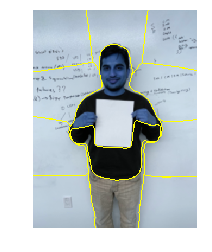

In [217]:
numSegments = 10
sigma = 5
compactness = 30
segments = slic(r_img, n_segments = numSegments, sigma = sigma,
               enforce_connectivity = True, compactness = compactness)
# show the output of SLIC
fig = plt.figure("Superpixels -- %d segments" % (numSegments))
ax = fig.add_subplot(1, 1, 1)
boundaries = mark_boundaries(r_img, segments, mode = 'thick')
ax.imshow(boundaries)
plt.axis("off")

In [220]:
from skimage.filters import roberts

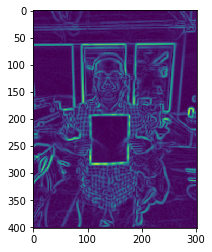

In [255]:
r = 9
filename = 'julian.jpg'
img = cv2.imread(filename)
r_img = imutils.resize(img, width=int(0.1*np.shape(img)[1]))
filt_img = cv2.GaussianBlur(r_img[:,:,0],(r,r),0)
img_roberts = roberts(filt_img)
plt.imshow(img_roberts)
img_roberts = cv2.normalize(src=img_roberts, dst=None, alpha=0, beta=255, 
               norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

In [257]:
#img_roberts.convertTo(img_roberts, CV_8UC1, 1/256.0)
cnts = cv2.findContours(img_roberts, mode = 3, method = 1)
cnts = cv2.findContours(img_roberts, cv2.RETR_EXTERNAL, 
                        cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

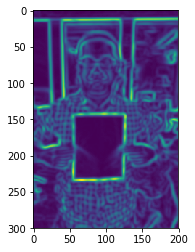

In [258]:
crop = img_roberts[50:350, 50:250]
bi = cv2.bilateralFilter(crop, 5, 75, 75)
plt.imshow(bi)

In [262]:
dst = cv2.cornerHarris(bi, 2, 3, 0.04)

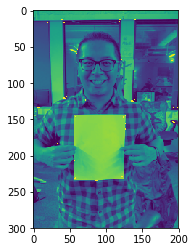

In [263]:
r_img_crop = r_img[50:350,50:250,0]
mask = np.zeros_like(r_img_crop)

#--- applying a threshold and turning those pixels above the threshold to white ---           
mask[dst>0.1*dst.max()] = 255
cv2.imshow('mask', mask)
r_img_crop[dst > 0.1 * dst.max()] = 255
cv2.imshow('dst', r_img_crop)
plt.imshow(r_img_crop)